# **STOCK MARKET PREDICTIONS**

# **Data Preprocessing**
The data is scraped from the Alpha_Vantage API and converted to the form necessary for our use.

In [2]:
#!pip install alpha_vantage

     |████████████████████████████████| 1.2MB 10.8MB/s 
     |████████████████████████████████| 153kB 50.8MB/s 
     |████████████████████████████████| 256kB 26.0MB/s 
  Created wheel for alpha-vantage: filename=alpha_vantage-2.2.0-cp36-none-any.whl size=25705 sha256=b65c2abf8676a3df8a9d04c1a04078f941b1e016cd6e152d5b217a2886e67643
  Stored in directory: /root/.cache/pip/wheels/3a/fa/05/80b0afcbd2a4de8bd2a0c5cd77084e3d3a9cc12c48be9b7f84
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3162 sha256=c27317bcf903242f1af570c2d7ea839331080d8bd42517c0ac2ce66a45eecc86
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built alpha-vantage idna-ssl


In [11]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from pandas import get_dummies
import math
import json
import sys
import csv
import os
import tqdm
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from tqdm import tqdm_notebook
%matplotlib inline
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import matplotlib
import matplotlib.pyplot as plt
import os
API_KEY = ''

ts = TimeSeries(key= API_KEY, output_format='pandas')
data, meta_data = ts.get_daily_adjusted(symbol='MSFT', outputsize='full')

X = data.drop(['7. dividend amount', '8. split coefficient'],axis=1)[::-1]
X.rename(columns={'1. open':'open', '2. high':'high', '4. close':'close', '6. volume':'volume', '3. low':'low', '5. adjusted close':'adj_close'}, inplace=True)
X

,open,high,low,close,adj_close,volume
date,,,,,,
2000-07-03,79.6900,80.06,79.37,80.00,25.6498,7867400.0
2000-07-05,79.8700,79.87,78.25,78.50,25.1689,17412200.0
2000-07-06,78.8700,81.69,78.50,80.94,25.9512,23936600.0
2000-07-07,81.2700,82.87,80.56,82.00,26.2910,27076600.0
2000-07-10,80.6900,81.31,79.37,79.44,25.4702,26344900.0
...,...,...,...,...,...,...
2020-06-26,199.7300,199.89,194.88,196.33,196.3300,54675780.0
2020-06-29,195.7800,198.53,193.55,198.44,198.4400,26701586.0
2020-06-30,197.8816,204.40,197.74,203.51,203.5100,34310283.0


In [5]:
varInput = X[["open", "high", "low", "close", "adj_close"]]
varInput

,open,high,low,close,adj_close
date,,,,,
2000-07-03,79.6900,80.06,79.37,80.00,25.6498
2000-07-05,79.8700,79.87,78.25,78.50,25.1689
2000-07-06,78.8700,81.69,78.50,80.94,25.9512
2000-07-07,81.2700,82.87,80.56,82.00,26.2910
2000-07-10,80.6900,81.31,79.37,79.44,25.4702
...,...,...,...,...,...
2020-06-26,199.7300,199.89,194.88,196.33,196.3300
2020-06-29,195.7800,198.53,193.55,198.44,198.4400
2020-06-30,197.8816,204.40,197.74,203.51,203.5100


# **Time Series Model**
Applying the Vector Autoregression Model to get the predictions for the next steps.

The AIC (Akaike Information Criterion) is used to determine the goodness of fit for any time series based model. The smaller the AIC vale, the better the model fits the data. Hence, here we use the aic value of 11 for fitting the model.

In [37]:
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random

model = VAR(varInput)
for i in range(12):
  model_fit = model.fit(i)
  print(i, model_fit.aic)

0 8.856245236452942
1 -6.168098304096419
2 -6.332083380126566
3 -6.381117711222273
4 -6.469807765259604
5 -6.493784331200622
6 -6.520908865890443
7 -6.563914522533071
8 -6.623165118738657
9 -6.671753359018193
10 -6.7094693360244495
11 -6.741098937082745


Fitting the model and generating the forecast for 15 steps.

In [21]:
model_fit = model.fit(11)
yhat = model_fit.forecast(model_fit.y, steps=15)
print(yhat.shape)

(15, 5)


Observing the trend for the predicted values of the stock prices for their corresponding categories.

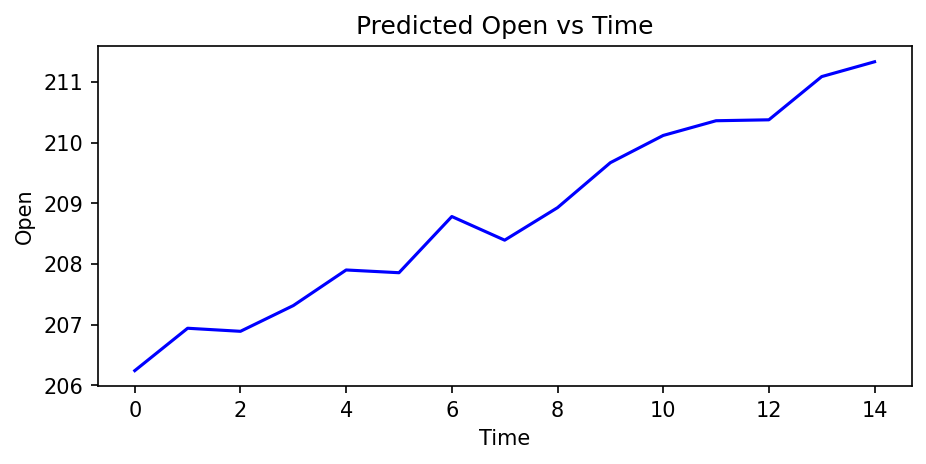

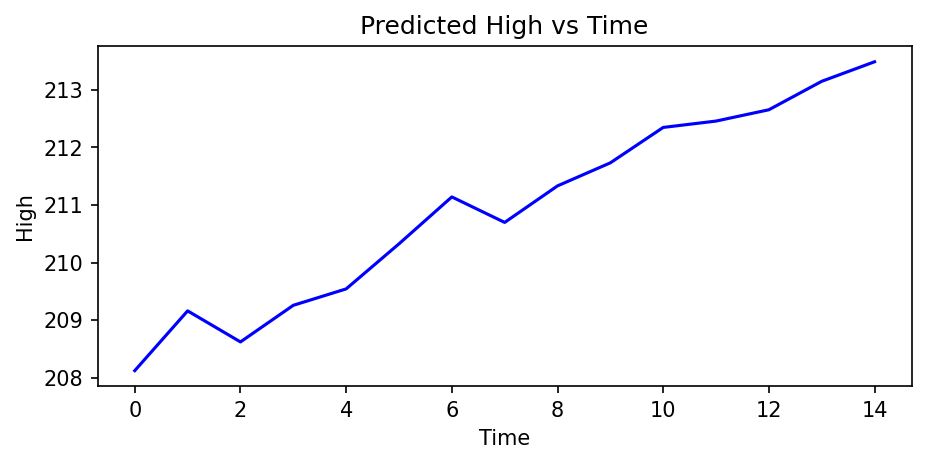

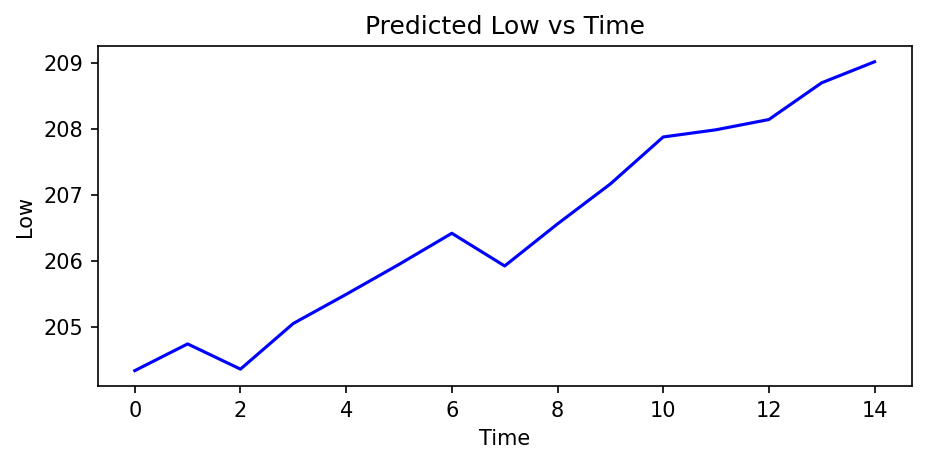

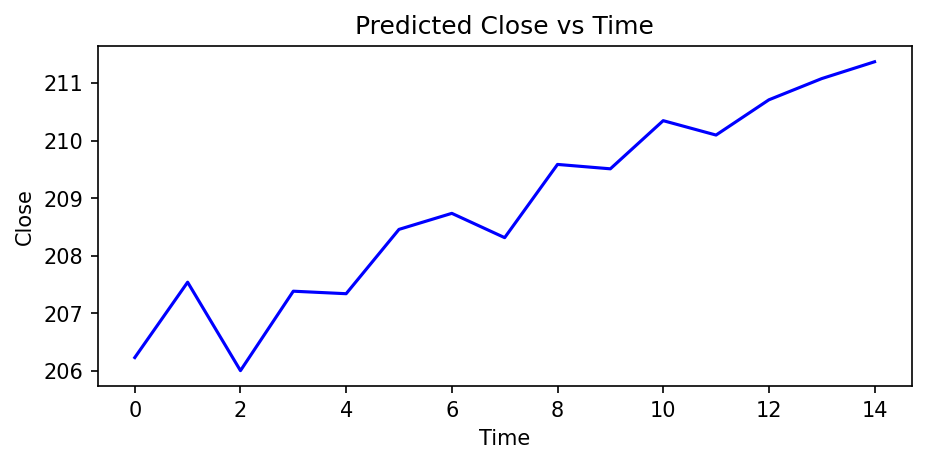

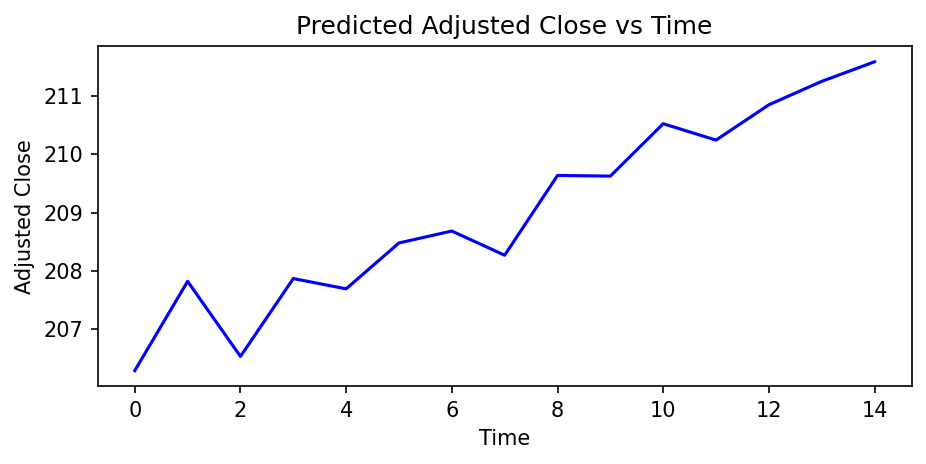

In [40]:
colNames = ['Open', 'High', 'Low', 'Close', 'Adjusted Close']

for i in range(yhat.shape[1]):
  figure(num=None, figsize=(7, 3), dpi=150, facecolor='w', edgecolor='k')
  plt.plot(yhat[:,i], color = 'blue')
  plt.title('Predicted '+ colNames[i] + ' vs Time')
  plt.xlabel('Time')
  plt.ylabel(colNames[i])
  plt.show()

# **RNN (LSTM) Model**
Applying Deep Learning Model to the dataset helps us to predict the data better that the traditional Time Series Analysis Technique.

In [23]:
stockData = X[['open', 'high', 'low', 'close', 'adj_close']]
stockData = np.array(stockData)
stockData.shape

(5032, 5)

Splitting the data into 85% for training and 15% for validation.

In [24]:
splitIndex = int(stockData.shape[0]*0.85)
stockTrain = stockData[:splitIndex, :]
stockTest = stockData[splitIndex:, :]

Scaling the dynamic column data to the same scale range.

In [25]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(stockTrain)
testing_scaled = sc.fit_transform(stockTest)

Creating windows using 15 samples as the input to predict the next sample, which is also set as the target sample.

In [26]:
n_len = 15

x_train = []
y_train = []
for i in range(n_len,len(training_scaled)):
    x_train.append(training_scaled[i-n_len:i, :])
    y_train.append(training_scaled[i,:])
x_train,y_train = np.array(x_train),np.array(y_train)
print(x_train.shape)

x_test = []
y_test = []
for i in range(n_len,len(testing_scaled)):
    x_test.append(testing_scaled[i-n_len:i, :])
    y_test.append(testing_scaled[i,:])
x_test,y_test = np.array(x_test),np.array(y_test)

print(x_test.shape)

(4262, 15, 5)
(740, 15, 5)


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Bidirectional
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout, BatchNormalization

Defining the LSTM model.

In [28]:
from tensorflow.keras.backend import clear_session
clear_session()

model_lstm = Sequential()
model_lstm.add(LSTM(units = 75,return_sequences = True,input_shape = (x_train.shape[1],x_train.shape[2])))
model_lstm.add(LSTM(units = 75,return_sequences = True))

model_lstm.add(Dense(units = 100, activation = 'relu'))
model_lstm.add(Dropout(0.15))

model_lstm.add(Dense(units = 96, activation = 'relu'))
model_lstm.add(Dropout(0.1))

model_lstm.add(Dense(units = 32, activation = 'relu'))
model_lstm.add(Dropout(0.05))

model_lstm.add(Dense(units = stockData.shape[1]))

model_lstm.compile(optimizer = 'adam',loss = 'mean_absolute_error')

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 75)            24300     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 75)            45300     
_________________________________________________________________
dense (Dense)                (None, 15, 100)           7600      
_________________________________________________________________
dropout (Dropout)            (None, 15, 100)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 15, 96)            9696      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 96)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 15, 32)            3

Fitting the model to the training data, while monitoring the Mean Absolute Error Loss.

In [41]:
model_lstm.fit(x_train,y_train,epochs = 5, batch_size = 1)

Epoch 1/5
4262/4262 [==============================] - 20s 5ms/step - loss: 0.0260
Epoch 2/5
4262/4262 [==============================] - 20s 5ms/step - loss: 0.0257
Epoch 3/5
4262/4262 [==============================] - 19s 5ms/step - loss: 0.0258
Epoch 4/5
4262/4262 [==============================] - 19s 5ms/step - loss: 0.0258
Epoch 5/5
4262/4262 [==============================] - 20s 5ms/step - loss: 0.0255


Predicting the model on the testing data and visualizing the results.

In [42]:
predictedValues = model_lstm.predict(x_test)
predictedValues = predictedValues[:,-1,:]
predictedValues = sc.inverse_transform(predictedValues)
predictedValues.shape

(740, 5)

In [43]:
# for i in range(predictedValues.shape[0]):
#   print(stockTest[i,0] , '  ' , predictedValues[i,0])

# plt.plot(stockTest[:predictedValues.shape[0],0],color = 'red', label = 'True_Values')
# plt.plot(predictedValues[:,0], color = 'blue', label = 'Predicted_Values')
# plt.title('Open')
# plt.legend()
# plt.show()

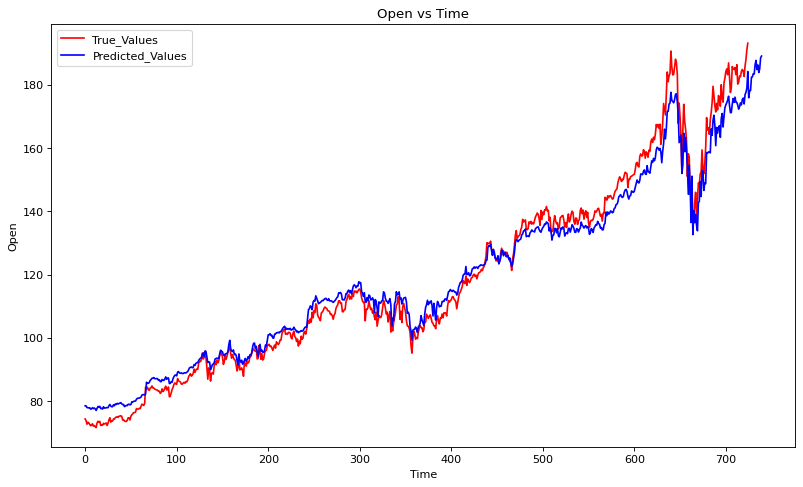

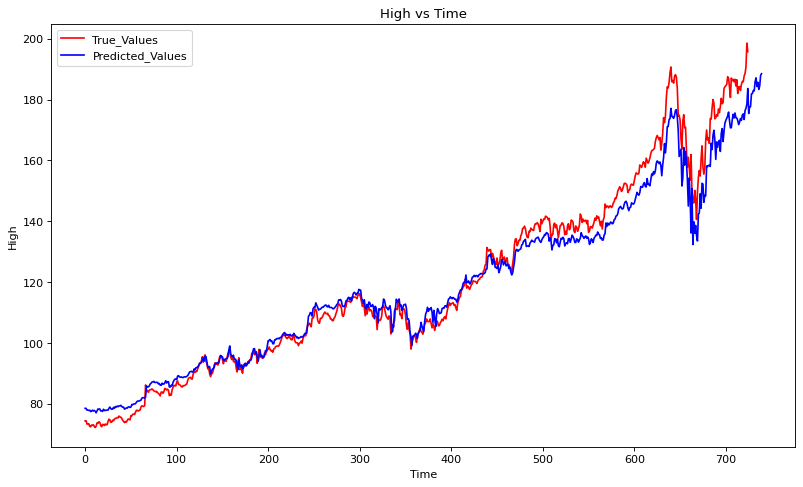

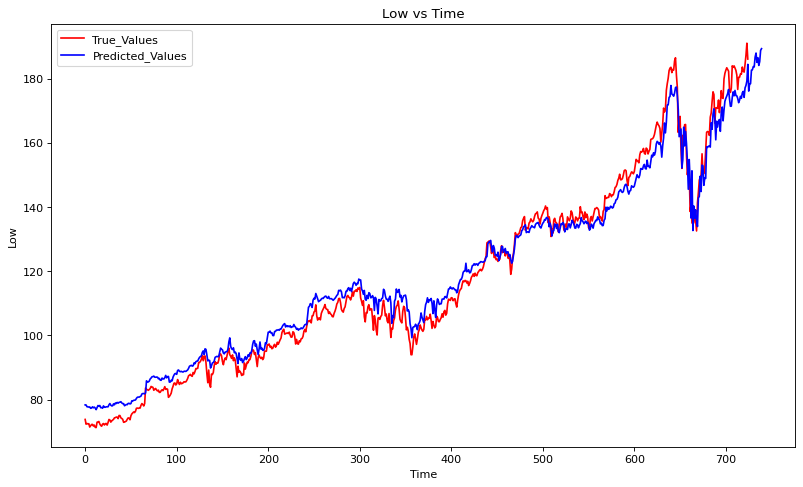

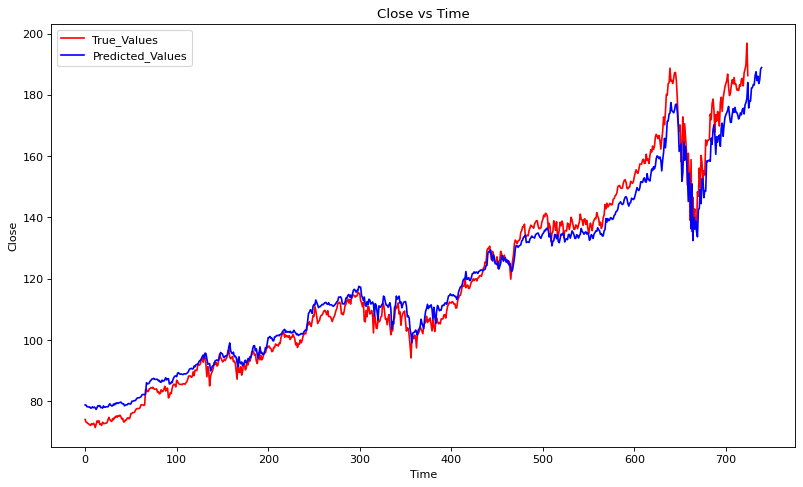

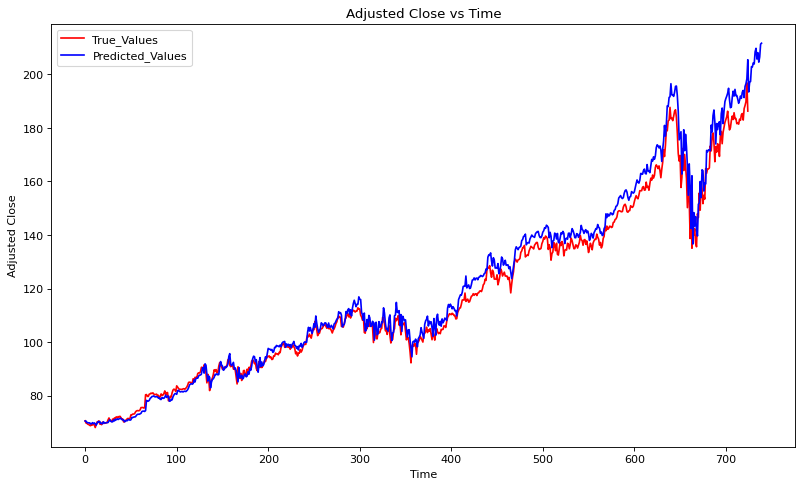

In [44]:
colNames = ['Open', 'High', 'Low', 'Close', 'Adjusted Close']

for i in range(stockTest.shape[1]):
  figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
  plt.plot(stockTest[n_len:predictedValues.shape[0],i],color = 'red', label = 'True_Values')
  plt.plot(predictedValues[:,i], color = 'blue', label = 'Predicted_Values')
  plt.title(colNames[i] + ' vs Time')
  plt.xlabel('Time')
  plt.ylabel(colNames[i])
  plt.legend()
  plt.show()